<h1>Click Through Rate Prediction for ads</h1>

In [1]:
import sys
sys.path.insert(0,'C:/users/stone/anaconda3/envs/env1/lib/site-packages')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn import metrics
from time import time
from tqdm import tqdm

from imblearn.over_sampling import SMOTE
import joblib

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
data=pd.read_csv('data.csv')
data.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C17,C18,C19,C20,C21,month,dayofweek,day,hour,y
0,False,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,2528,0,39,100075,221,10,1,28,14,0
1,True,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1934,2,39,-1,16,10,2,22,19,1
2,False,1005,0,e3c09f3a,d262cf1e,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,2552,3,167,100202,23,10,3,23,18,0
3,False,1002,0,0da94452,248e439f,50e219e0,ecad2386,7801e8d9,07d7df22,0fa578fd,...,2478,3,167,100074,23,10,2,22,19,0
4,True,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1722,0,35,-1,79,10,1,21,8,1


In [4]:
print(data.shape)

(99999, 27)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   click             99999 non-null  bool  
 1   C1                99999 non-null  int64 
 2   banner_pos        99999 non-null  int64 
 3   site_id           99999 non-null  object
 4   site_domain       99999 non-null  object
 5   site_category     99999 non-null  object
 6   app_id            99999 non-null  object
 7   app_domain        99999 non-null  object
 8   app_category      99999 non-null  object
 9   device_id         99999 non-null  object
 10  device_ip         99999 non-null  object
 11  device_model      99999 non-null  object
 12  device_type       99999 non-null  int64 
 13  device_conn_type  99999 non-null  int64 
 14  C14               99999 non-null  int64 
 15  C15               99999 non-null  int64 
 16  C16               99999 non-null  int64 
 17  C17         

Columns don't seem to have any missing values. All variables are categorical


<h3>Data Exploration</h3>

<h4>Utility functions</h4>

In [10]:
## Function to clean categorical columns with multiple levels and plot

def cleancol(df,col,replace_with):
    '''
    inputs
    ------------------------
    df- dataframe
    col- categorical column in the dataframe
    
    output
    -------------------------
    The cleaned categorical column with fewer levels
    '''
    x1=100*df[col].value_counts(normalize=1)
    
    # identifying categories that are less than 15 of total 
    ids_to_replace=list(x1[x1<1].index)
    
    #Replacing the rare categories with a constant
    df[col]=df[col].apply(lambda x:replace_with if x in ids_to_replace else x)
    return df[col]


def gen_barplot(df,col,order=[]):
    '''accepts a dataframe and the name of a categorical column to generate barplot on'''
    '''order is an optional list that can be passed to the function in which bars in the barplot will be arranged'''
    '''Otherwise bars will be ordered from most frequent to least frequent'''
    col_count=df[col].value_counts()
    n_total=col_count.sum()
    col_order=col_count.index
    base_color='#1D5C63'
    fig,ax=plt.subplots(figsize=(10,5))
    
    # showing propotion on the bars
    if order==[]:
        sns.countplot(data=df,y=col,color=base_color,order=col_order,ax=ax)
        for i in range(len(col_count)):
            count=col_count[i]
            pct_string='{:0.1f}%'.format(100*count/n_total)
            plt.text(count+1,i,pct_string,va='center')
    else:
        sns.countplot(data=df,y=col,color=base_color,order=order,ax=ax)
        for i in range(len(order)):
            count=col_count[order[i]]
            pct_string='{:0.1f}%'.format(100*count/n_total)
            plt.text(count+1,i,pct_string,va='center')  
            
    plt.title(col+' vs percent traffic')
    plt.ylabel(col)
    plt.xlabel('count');
    return fig

def plot_bar(df,col):
    base_color='#1D5C63'
    fig,ax=plt.subplots(figsize=(10,5))
    df[col].value_counts(normalize=True).plot(kind='bar',color=base_color,ax=ax)
    plt.title(col+' vs percent traffic')
    plt.ylabel('% of total traffic')
    plt.xlabel(col);
    return fig
    

<h4>Click</h4>

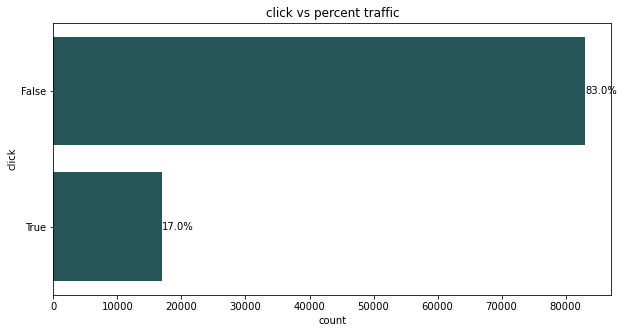

In [11]:
# Exploring the target variable
gen_barplot(data,'click');

<p>It can be seen that only 17% data belogs to the positive class while 83% belongs to the negative class</p>

In [8]:
cols_to_plot=list(data.columns)

for col in tqdm(cols_to_plot):
    if col not in ['click','device_ip']:
        data[col]=cleancol(data,col,col+'_other')


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:29<00:00,  1.08s/it]


In [13]:
# Dropping the month column as all have same value
# dropping click as y and click both represent the same data
data.drop(['month','click'],axis=1,inplace=True)
print('Done!')

Done!


In [ ]:
<break>

click 'click'
month 'month'


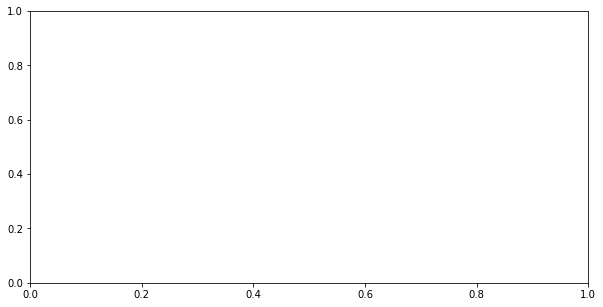

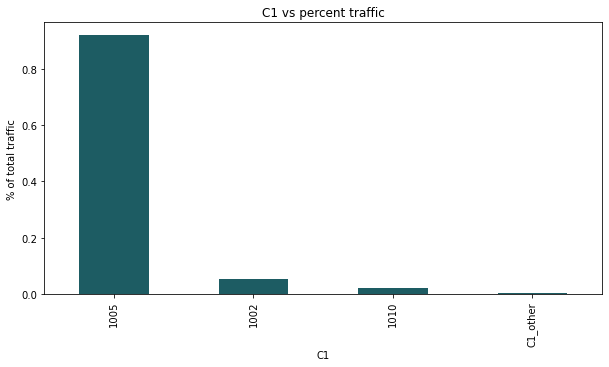

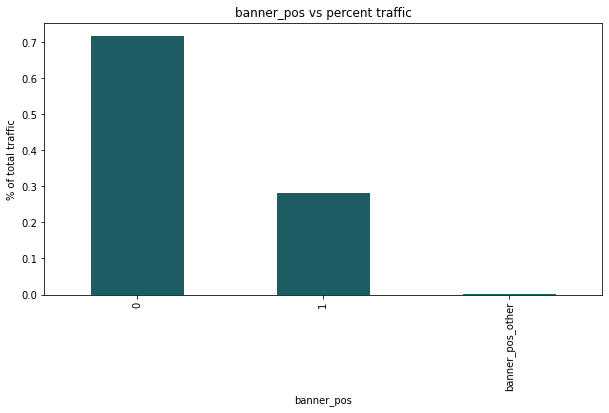

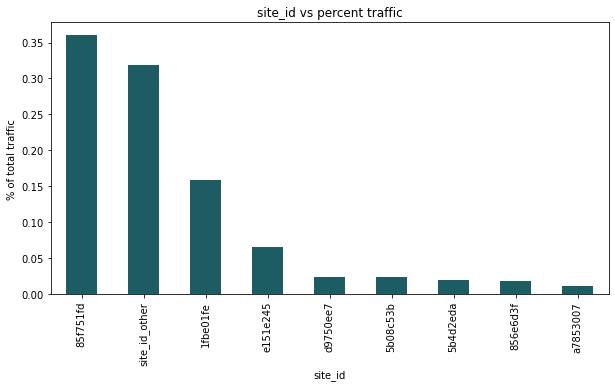

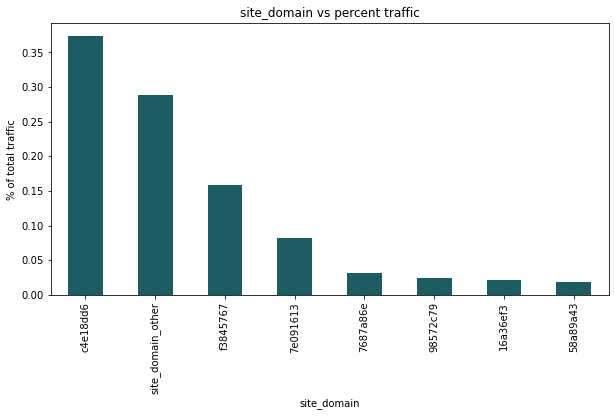

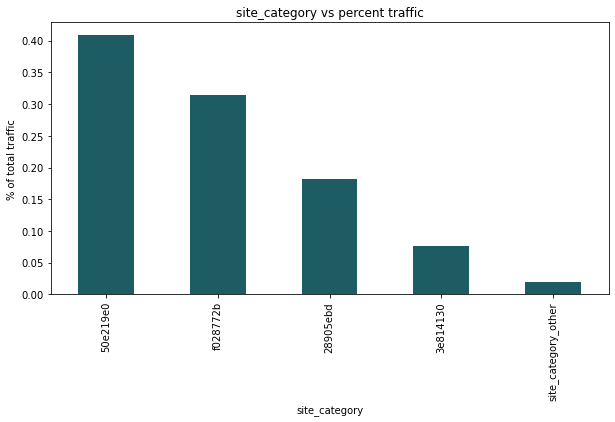

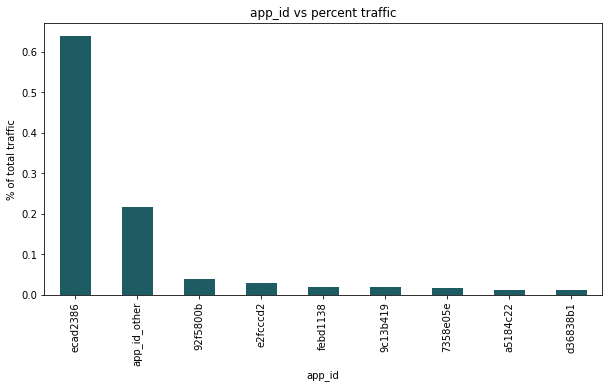

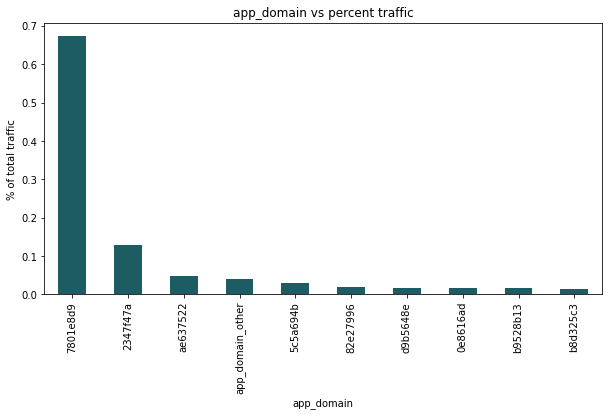

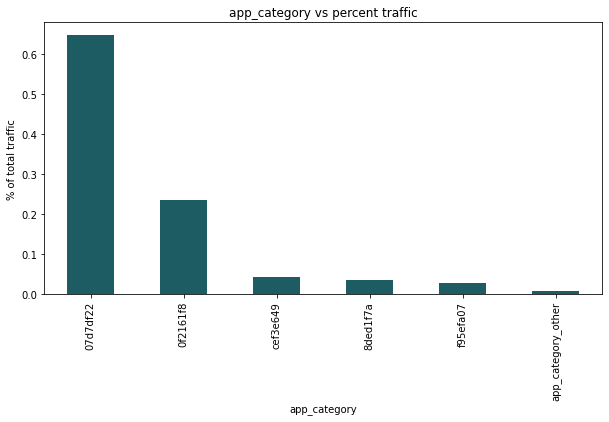

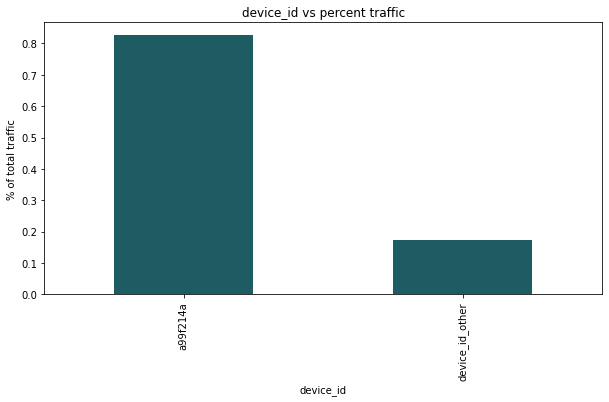

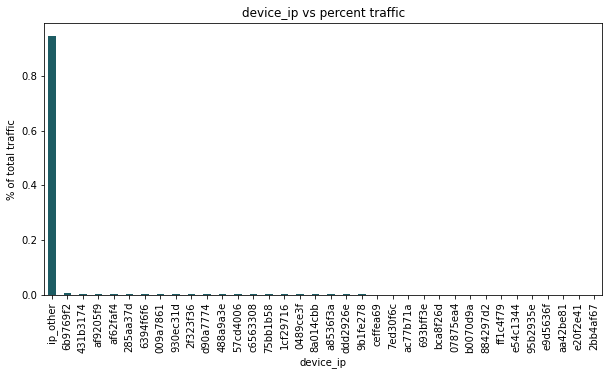

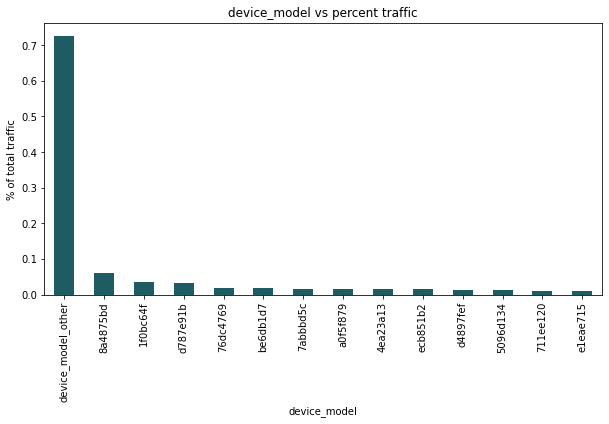

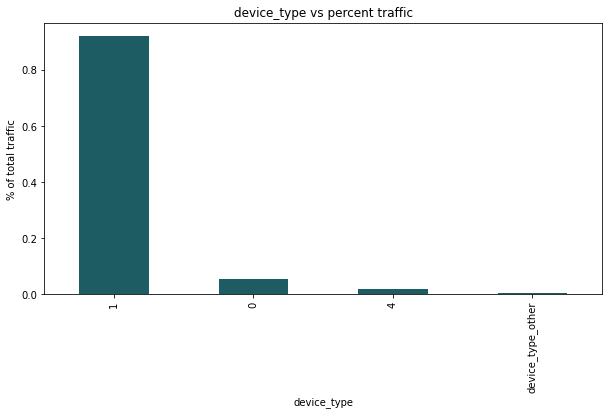

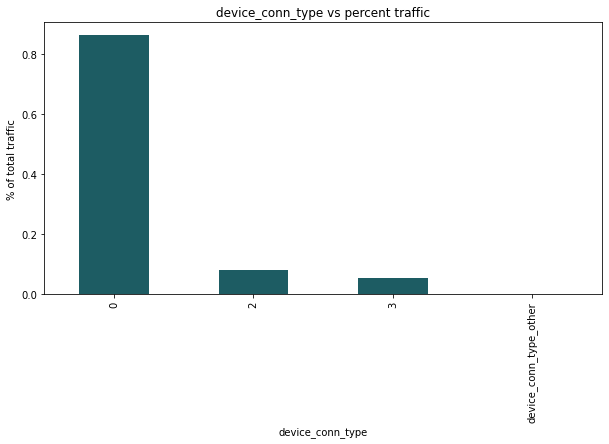

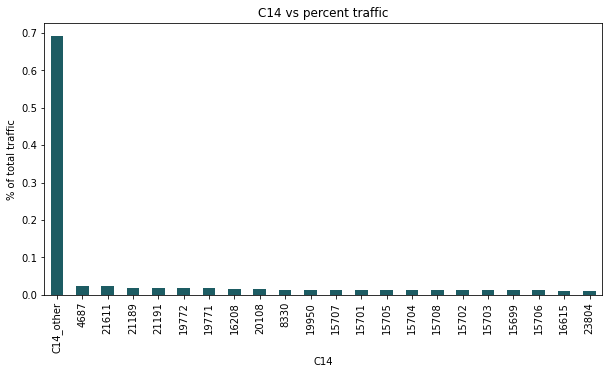

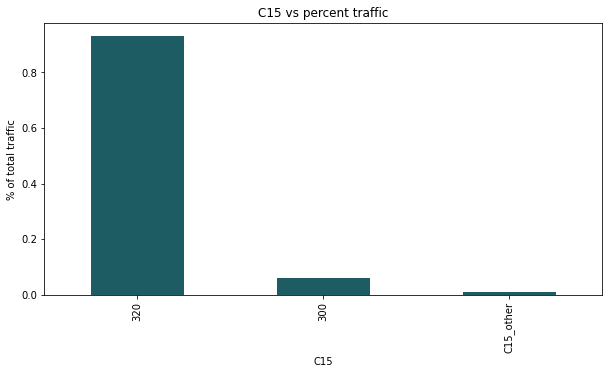

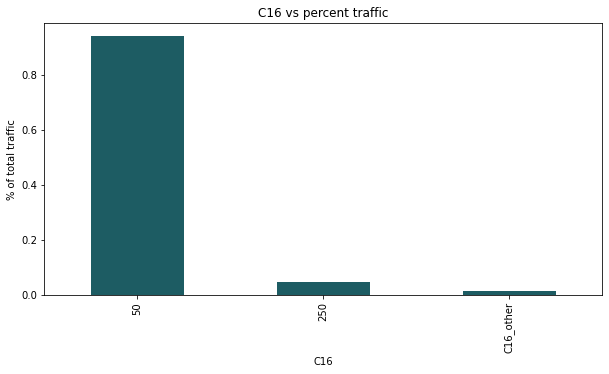

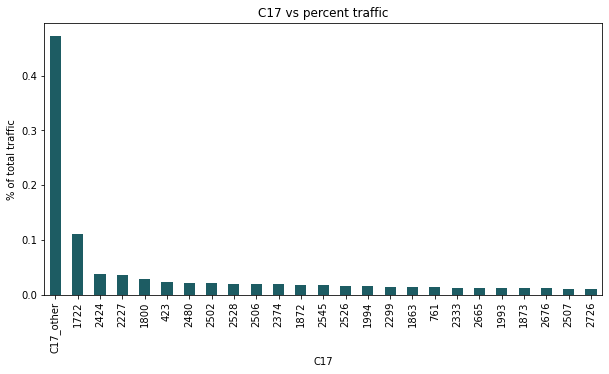

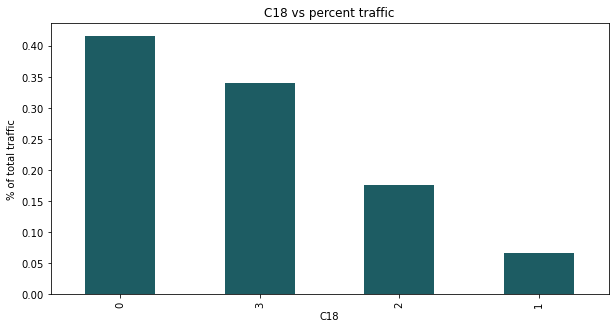

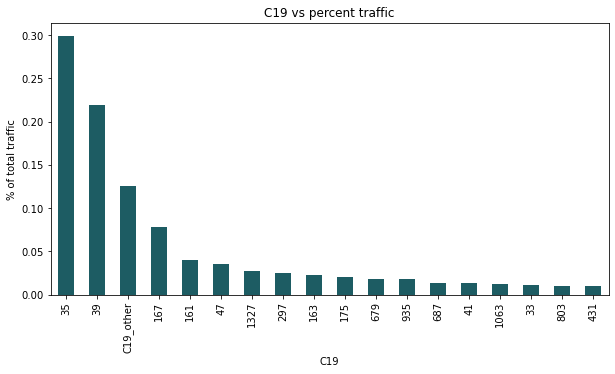

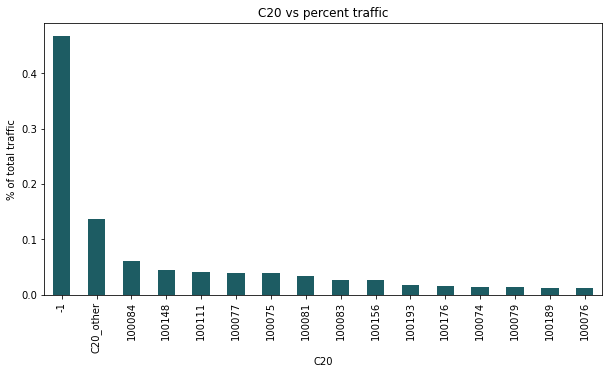

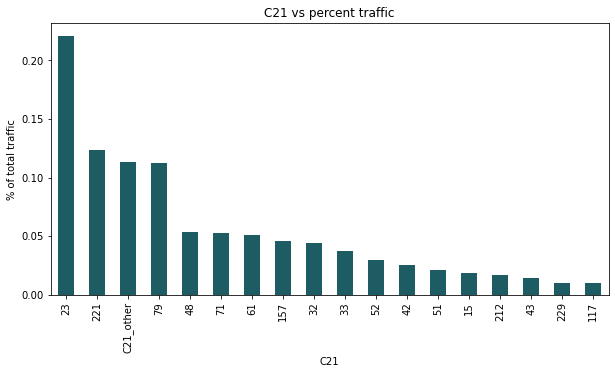

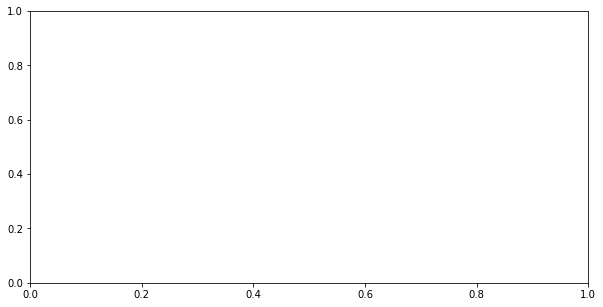

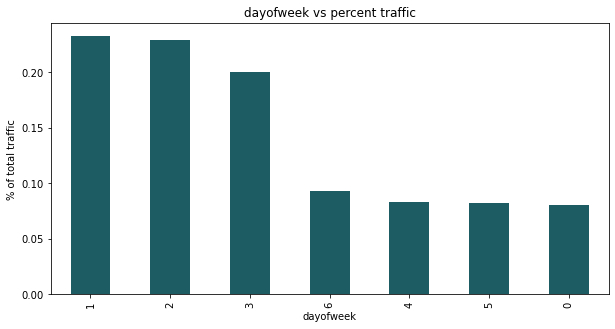

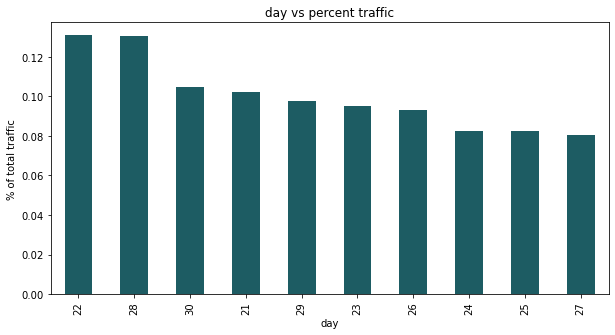

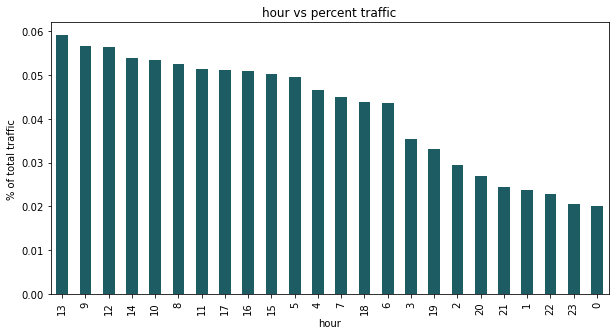

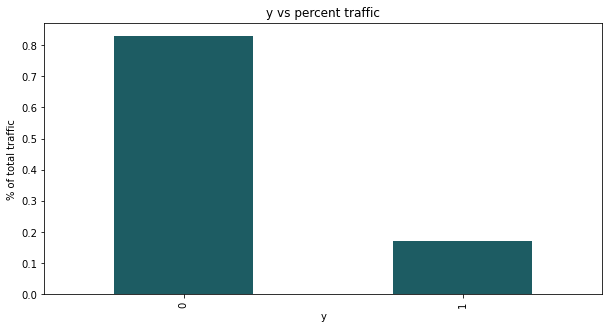

In [15]:
# Plotting

for col in cols_to_plot:
    try:
#         gen_barplot(data,col)
        plot_bar(data,col);
            
    except Exception as e:
        print(col,e)

In [9]:
# Aggregating device ip separately
x1=data['device_ip'].value_counts()
ids_to_replace=list(x1[x1<=50].index)

data['device_ip']=data['device_ip'].apply(lambda x:'ip_other' if x in ids_to_replace else x)
data['device_ip'].value_counts()

ip_other    94490
6b9769f2      521
431b3174      341
af9205f9      236
af62faf4      227
285aa37d      222
6394f6f6      219
009a7861      217
930ec31d      213
2f323f36      209
d90a7774      204
488a9a3e      193
57cd4006      186
c6563308      183
75bb1b58      180
1cf29716      178
0489ce3f      171
8a014cbb      163
a8536f3a      161
ddd2926e      155
9b1fe278      146
ceffea69      139
7ed30f6c      109
ac77b71a       98
693bff3e       92
bca8f26d       90
07875ea4       80
b0070d9a       80
884297d2       69
ff1c4f79       68
e54c1344       65
95b2935e       64
e9d5636f       63
aa42be81       58
e20f2e41       56
2bb4af67       53
Name: device_ip, dtype: int64

In [30]:
# Checking number of levels per categorical column
for col in data.columns:
    print(col+'---'+str(data[col].nunique()))
    

C1---4
banner_pos---3
site_id---9
site_domain---8
site_category---5
app_id---9
app_domain---10
app_category---6
device_id---2
device_ip---36
device_model---14
device_type---4
device_conn_type---4
C14---22
C15---3
C16---3
C17---25
C18---4
C19---18
C20---16
C21---18
dayofweek---7
day---10
hour---24
y---2


In [31]:
# Separating data into features and target
y=data['y']
X=data.drop('y',axis=1)
print(X.shape)
print(y.shape)

(99999, 24)
(99999,)


In [32]:
# Onehot encoding
X_enc=pd.get_dummies(X,drop_first=True)

#Train-test split
X_train,X_test,y_train,y_test=train_test_split(X_enc,y,test_size=0.3,random_state=42)

print('X_train: ',X_train.shape)
print('y_train: ',y_train.shape)
print('X_test: ',X_test.shape)
print('y_test: ',y_test.shape)

X_train:  (69999, 203)
y_train:  (69999,)
X_test:  (30000, 203)
y_test:  (30000,)


<h4>Creating dummy classifier</h4>

In [33]:
# Creating a baseline classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,f1_score

dummy=DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)
pred_test=dummy.predict(X_test)
print('accuracy: ',accuracy_score(y_test,pred_test))
print('f1_score: ',f1_score(y_test,pred_test))

accuracy:  0.8296
f1_score:  0.0


<h4>Choosing a suitable metric to evaluate model performance</h4>

As can be seen from the dummy classifier performance, blindly predicting everything to be 0 will result in the prediction being correct 83% of the time. So f1 score will be chosen as the metric for evaluating model performance as optimizing f1 score will lead to minimizing false-positives and false-negatives which is very desireable in this case. Also since there is a considerable class imbalance, class weights will be used to counteract this effect

<h4>Simple Logistic Regression</h4>

In [ ]:
# Fitting logistic regression with Lasso for feature selection
# RFE is very computationally expensive to run on a dataset with 203 features

start=time()
model=LogisticRegression(max_iter=1000,solver='saga',penalty='l1',C=0.7)
model.fit(X_train,y_train)
print(time()-start)

285.6425709724426


The One-Hot encoded dataframe has 203 features. But not all features seem very useful. So lasso regularization with logistic regression will be used for feature selection since it will help in reducing dimensionality of the data and help in faster convergence

In [ ]:
# Creating a Dataframe with feature names and feature importances
imp=pd.DataFrame({'features':model.feature_names_in_,'feat_imp':np.ravel(model.coef_)})

imp.sort_values(by='feat_imp',ascending=False,key=lambda x:abs(x),inplace=True)

#Selecting variables having abs(feature importance) greater than 0.1
selected_features=imp.loc[imp['feat_imp'].apply(lambda x:abs(x))>0.1].reset_index(drop=True)

feat_list=list(selected_features['features'])
print('Number of selected features: ',len(feat_list))



Number of selected features:  120


In [ ]:
# writing selected feature names to a file
with open('selected_features.txt','w+') as f:
    for feat in feat_list:
        f.write(feat+'\n')

In [34]:
# retrieving selected features from a file
with open('selected_features.txt','r') as f:
    flist=f.read()
    
feat_list=flist.split('\n')
feat_list=[x for x in feat_list if x!='']

In [35]:
# Constructing training and test datasets  
X_train1=X_train[feat_list]
X_test1=X_test[feat_list]

In [ ]:
# Fitting a new model with smaller number of features
model2=LogisticRegression(max_iter=1000,solver='saga',penalty='l2',C=1)

model2.fit(X_train1,y_train)
print('accuracy: ',accuracy_score(y_test,model2.predict(X_test1)))
print('f1_score: ',f1_score(y_test,model2.predict(X_test1)))

accuracy:  0.8313333333333334
f1_score:  0.0739385065885798


It can be seen that the model with 120 features performs marginally better than the baseline dummy classifier with 203 features. But reduction in dimensionality has been achieved.

<h4>RandomForest Classifier</h4>

In [ ]:
# Simple RandomForest Classifier
rf=RandomForestClassifier(random_state=42,class_weight={0:0.3,1:0.7})
rf.fit(X_train1,y_train)

print('accuracy: ',accuracy_score(y_test,rf.predict(X_test1)))
print('f1_score: ',f1_score(y_test,rf.predict(X_test1)))

accuracy:  0.7963333333333333
f1_score:  0.3224661787536039


In [ ]:
# Parameter optimization for random Forest
start=time()
params={
    'n_estimators':[300],
    'max_depth':[20,40,60],
    'min_samples_split':[1,2,4],
    'min_samples_leaf':[1,7]
    }

grid_rf=GridSearchCV(rf,param_grid=params,scoring=['accuracy','f1'],cv=3,refit='f1')
grid_rf.fit(X_train1,y_train)

print(time()-start)

795.1316075325012


In [ ]:
grid_rf.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [ ]:
print('accuracy: ',accuracy_score(y_test,grid_rf.predict(X_test1)))
print('f1_score: ',f1_score(y_test,grid_rf.predict(X_test1)))

accuracy:  0.8129333333333333
f1_score:  0.2841836734693878


In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 0.3, 1: 0.7},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [89]:
from lightgbm.callback import early_stopping
lgbc=lgb.LGBMClassifier(class_weight={0:0.3,1:0.7},
                        num_iterations=200,
                        objective='binary',
                        metric='binary_logloss',
                        num_boost_round=4000,
                        early_stopping=50
                        )
lgbc.fit(X_train1,y_train,eval_set=(X_test1,y_test))

print('--'*30)
print('accuracy: ',accuracy_score(y_test,lgbc.predict(X_test1)))
print('f1_score: ',f1_score(y_test,lgbc.predict(X_test1)))

[1]	valid_0's binary_logloss: 0.508835
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.503109
[3]	valid_0's binary_logloss: 0.498454
[4]	valid_0's binary_logloss: 0.494663
[5]	valid_0's binary_logloss: 0.491454
[6]	valid_0's binary_logloss: 0.488874
[7]	valid_0's binary_logloss: 0.486606
[8]	valid_0's binary_logloss: 0.484735
[9]	valid_0's binary_logloss: 0.483172
[10]	valid_0's binary_logloss: 0.481863
[11]	valid_0's binary_logloss: 0.480703
[12]	valid_0's binary_logloss: 0.479566
[13]	valid_0's binary_logloss: 0.478675
[14]	valid_0's binary_logloss: 0.47783
[15]	valid_0's binary_logloss: 0.477006
[16]	valid_0's binary_logloss: 0.476396
[17]	valid_0's binary_logloss: 0.47588
[18]	valid_0's binary_logloss: 0.475429
[19]	valid_0's binary_logloss: 0.475016
[20]	valid_0's binary_logloss: 0.474591
[21]	valid_0's binary_logloss: 0.474304
[22]	valid_0's binary_logloss: 0.474039
[23]	valid_0's binary_logloss: 0.473752
[24]	valid_0's binary_logloss

In [90]:
# Optimizing lightgbm with gridsearch
start=time()
params={
    # 'boosting_type':['gbdt','dart','goss'],
    'max_depth':[20],
    'learning_rate':[0.1],
    'n_estimators':[500],
    'colsample_bytree':[0.3],
    'subsample':[0.1],
    'min_split_gain':[0.3],
    'reg_alpha':[0.01],
    'reg_lambda':[0.1]
    }

grid_lgbc=GridSearchCV(lgbc,param_grid=params,scoring=['accuracy','f1'],cv=3,refit='f1')
grid_lgbc.fit(X_train1,y_train,eval_set=(X_test1,y_test),eval_metric='binary_logloss')
print(time()-start)

[1]	valid_0's binary_logloss: 0.511687
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.50726
[3]	valid_0's binary_logloss: 0.504143
[4]	valid_0's binary_logloss: 0.501132
[5]	valid_0's binary_logloss: 0.498812
[6]	valid_0's binary_logloss: 0.49587
[7]	valid_0's binary_logloss: 0.49414
[8]	valid_0's binary_logloss: 0.492341
[9]	valid_0's binary_logloss: 0.490595
[10]	valid_0's binary_logloss: 0.489422
[11]	valid_0's binary_logloss: 0.488197
[12]	valid_0's binary_logloss: 0.486851
[13]	valid_0's binary_logloss: 0.485351
[14]	valid_0's binary_logloss: 0.484777
[15]	valid_0's binary_logloss: 0.484108
[16]	valid_0's binary_logloss: 0.483164
[17]	valid_0's binary_logloss: 0.482646
[18]	valid_0's binary_logloss: 0.481932
[19]	valid_0's binary_logloss: 0.481312
[20]	valid_0's binary_logloss: 0.480739
[21]	valid_0's binary_logloss: 0.480495
[22]	valid_0's binary_logloss: 0.480036
[23]	valid_0's binary_logloss: 0.479796
[24]	valid_0's binary_logloss:

In [86]:
grid_lgbc.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_split_gain': 0.3,
 'n_estimators': 500,
 'reg_alpha': 0.01,
 'reg_lambda': 0.1,
 'subsample': 0.1}

In [91]:
print('accuracy: ',accuracy_score(y_test,grid_lgbc.predict(X_test1)))
print('f1_score: ',f1_score(y_test,grid_lgbc.predict(X_test1)))

accuracy:  0.8121666666666667
f1_score:  0.29641653140217256


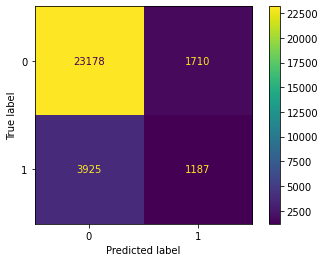

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(grid_lgbc, X_test1, y_test);

<h4>Risks of using the model in production</h4>

As can be seen from the different models, the f1 score of the classifiers is about 0.3 and there are a large number of false negatives. That is model predicts actual clicks as 0 which may lead the company to miss out on business oppotunity